## REGRESSÃO LOGÍSTICA
LOGISTIC REGRESSION

Você pode estar se perguntando - por que estamos usando um algoritmo de "regressão" em um problema de classificação? Embora o nome pareça indicar o contrário, a regressão logística é, na verdade, um algoritmo de classificação. Suspeito que seja assim chamado porque é muito semelhante à regressão linear em sua abordagem de aprendizado, mas as funções de custo e gradiente são formuladas de forma diferente. Em particular, a regressão logística usa uma função de ativação sigmóide ou “logit” em vez da saída contínua em regressão linear (daí o nome). Veremos mais adiante quando mergulharmos na implementação.


In [32]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
df = pd.read_csv('admissao.csv')
df.head() 

,Exame1,Exame2,Admitido
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Existem duas variáveis ​​independentes contínuas nos dados - "Exame 1" e "Exame 2". Nosso alvo de previsão é o rótulo "Admitido", que é de valor binário. Um valor de 1 significa que o aluno foi admitido e um valor de 0 significa que o aluno não foi admitido. Vamos ver isso graficamente com um gráfico de dispersão das duas pontuações e usar o código de cores para visualizar se o exemplo é positivo ou negativo.

Text(0,0.5,'Exam 2 Score')

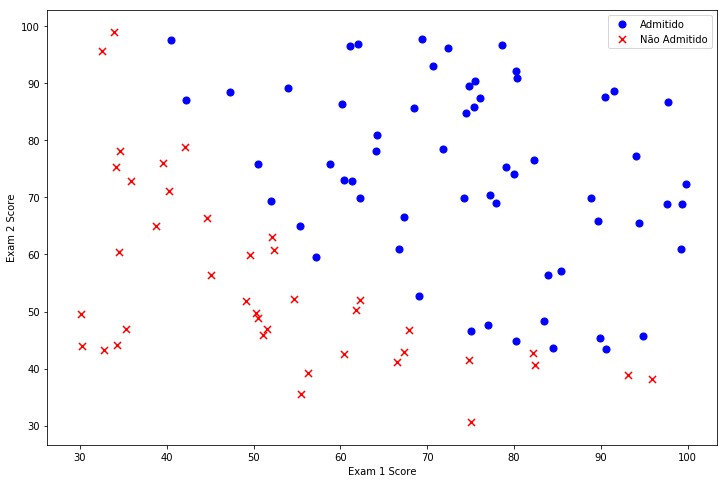

In [34]:
positive = df[df['Admitido'].isin([1])]  
negative = df[df['Admitido'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8)) 
ax.scatter(positive['Exame1'], positive['Exame2'], s=50, c='b', marker='o', label='Admitido')  
ax.scatter(negative['Exame1'], negative['Exame2'], s=50, c='r', marker='x', label='Não Admitido')  
ax.legend()  
ax.set_xlabel('Exam 1 Score')  
ax.set_ylabel('Exam 2 Score')  

Podemos ver que há um limite de decisão quase linear. Ele se curva um pouco, então não podemos classificar todos os exemplos corretamente usando uma linha reta, mas devemos ser capazes de chegar bem perto. 

Agora, precisamos implementar a regressão logística para que possamos treinar um modelo para encontrar o limite de decisão ideal e fazer previsões de classe. O primeiro passo é implementar a função sigmóide.

### SIGMOID

In [35]:
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))


Esta função é a função de “ativação” para a saída da regressão logística. Converte uma entrada contínua em um valor entre zero e um. Esse valor pode ser interpretado como a probabilidade da classe ou a probabilidade de que o exemplo de entrada seja classificado positivamente. Usando essa probabilidade junto com um valor limite, podemos obter uma previsão discreta de rótulo. Ajuda a visualizar a saída da função para ver o que ela está realmente fazendo.

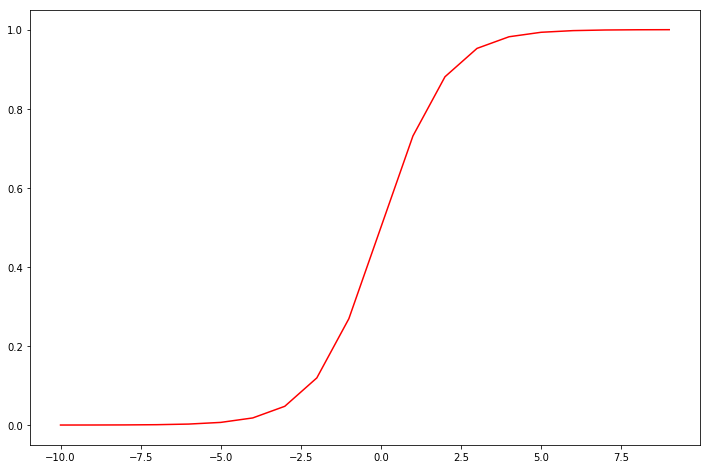

In [36]:
nums = np.arange(-10, 10, step=1)

fig, ax = plt.subplots(figsize=(12,8))  
ax.plot(nums, sigmoid(nums), 'r')  

## FUNÇÃO DE CUSTO 
Nosso próximo passo é escrever a função de custo. Lembre-se de que a função custo avalia o desempenho do modelo nos dados de treinamento, dado um conjunto de parâmetros do modelo. Aqui está a função de custo para a regressão logística.

In [37]:
def cost(w, X, y):    
    w = np.matrix(w)
    X = np.matrix(X)
    y = np.matrix(y)
    
    m = len(X)
    
    parte1 = np.multiply(-y, np.log(sigmoid(X @ w.T)))
    parte2 = np.multiply((1 - y), np.log(1 - sigmoid(X @ w.T)))
    
    somatorio = np.sum(parte1 - parte2)
    
    return  somatorio/m

Observe que reduzimos a saída para um único valor escalar, que é a soma do "erro" quantificado como uma função da diferença entre a probabilidade da classe atribuída pelo modelo e o rótulo verdadeiro do exemplo. A implementação é completamente vetorizada - está computando as previsões do modelo para todo o conjunto de dados em uma declaração (sigmóide (X * theta.T)). Se a matemática aqui não fizer sentido, consulte o texto do exercício ao qual eu estou ligado acima para uma explicação mais detalhada.

Podemos testar a função de custo para garantir que está funcionando, mas primeiro precisamos fazer algumas configurações.

# CONFIGURAÇÕES 

### ADICIONANDO A COLUNA X_ZERO
Adicionando a coluna x0 ao início do dataset toda com valores igual a 1

In [38]:
df.insert(0, 'X_ZERO', 1)

In [39]:
df.head()

,X_ZERO,Exame1,Exame2,Admitido
0,1,34.623660,78.024693,0
1,1,30.286711,43.894998,0
2,1,35.847409,72.902198,0
3,1,60.182599,86.308552,1
4,1,79.032736,75.344376,1


### SEPARANDO X de y 

In [40]:
# set X (training data) and y (target variable)
n_features = df.shape[1]-1  ## JÁ CONTANTO A COLUNA X0

X = np.array(df.drop('Admitido',1)) 
y = df.iloc[:,n_features:n_features+1].values

### Criando o vetor de parâmetros 

In [41]:
w = np.zeros(n_features)

## Verificando o formato dos dados

In [42]:
X.shape, w.shape, y.shape 

((100, 3), (3,), (100, 1))

## CÁLCULO DE TESTE
Agora vamos calcular o custo para a nossa solução inicial, dado zeros para os parâmetros do modelo, aqui representados como “w”.

In [43]:
cost(w, X, y) 

0.6931471805599453

## GRADIENT DESCENDENT

Agora que temos uma função de custo, a próxima etapa é escrever uma função que calcule o gradiente dos parâmetros do modelo para descobrir como alterar os parâmetros para melhorar o resultado do modelo nos dados de treinamento. Lembre-se de que, com o gradiente descendente, não apenas calculamos os valores dos parâmetros e vemos o que funciona melhor. Em cada iteração de treinamento, atualizamos os parâmetros de forma a garantir que eles sejam movidos em uma direção que reduz o erro de treinamento (ou seja, o "custo"). Podemos fazer isso porque a função custo é diferenciável. 

In [44]:
def gradient(w, X, y): 
    w = np.matrix(w)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(w.ravel().shape[1])
    grad = np.zeros(parameters)

    error = sigmoid(X * w.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / len(X)

    return grad

Na verdade não realizamos gradiente descendente nesta função - apenas calculamos um único passo de gradiente.  podemos usar a API de otimização do SciPy para fazer a mesma coisa.

### OTIMIZADOR
Criando um otimizado com a biblioteca SciPy

https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

In [70]:
from scipy.optimize import minimize
res = minimize(cost, w, args=(X,y), method=None, jac=gradient, options={'maxiter':1000})
res

      fun: 0.20349770158947425
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([8.89622886e-09, 7.59647888e-08, 4.78664200e-07])
  message: 'Optimization terminated successfully.'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-25.16131872,   0.20623159,   0.20147149])

In [61]:
w = res.x

In [47]:
w

array([-25.16131872,   0.20623159,   0.20147149])

## PLOTANDO O LIMITE DE DECISÃO

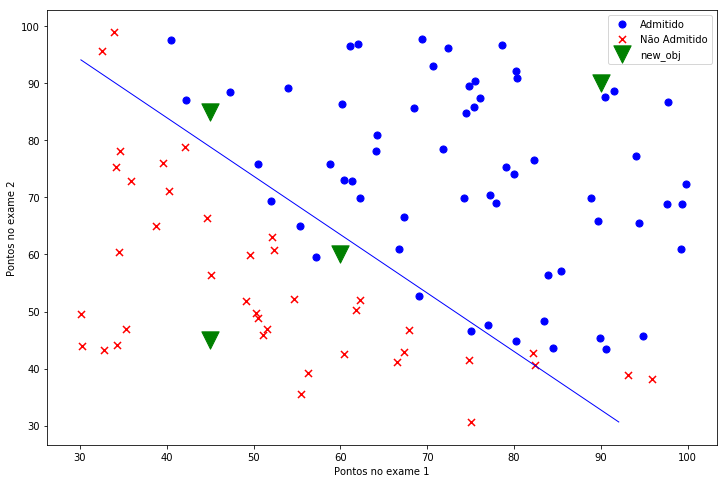

In [67]:
x1_min, x1_max = X[:,1].min(), X[:,1].max(),
x2_min, x2_max = X[:,2].min(), X[:,2].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid(np.c_[np.ones((xx1.ravel().shape[0],1)), xx1.ravel(), xx2.ravel()].dot(w))
h = h.reshape(xx1.shape)

fig, ax = plt.subplots(figsize=(12,8)) 
ax.scatter(positive['Exame1'], positive['Exame2'], s=50, c='b', marker='o', label='Admitido')  
ax.scatter(negative['Exame1'], negative['Exame2'], s=50, c='r', marker='x', label='Não Admitido')  

ax.set_xlabel('Pontos no exame 1')  
ax.set_ylabel('Pontos no exame 2')  

plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')


plt.scatter(45, 85, s=300, c='g', marker='v', label='new_obj') ## VISULALIZANDO UM NOVO VALOR PARA PREDIÇÃO
plt.scatter(90, 90, s=300, c='g', marker='v') ## VISULALIZANDO UM NOVO VALOR PARA PREDIÇÃO
plt.scatter(45, 45, s=300, c='g', marker='v') ## VISULALIZANDO UM NOVO VALOR PARA PREDIÇÃO
plt.scatter(60, 60, s=300, c='g', marker='v') ## VISULALIZANDO UM NOVO VALOR PARA PREDIÇÃO



ax.legend()  

## REALIZANDO UMA PREDIÇÃO

In [68]:
def predict(w, X, threshold=0.5):
    p = sigmoid(X @ w.T) >= threshold
    return(p.astype('int'))

#### NOVO ESTUDANTE 1
Exame 1 = 45 <br/>
Exame 2 = 85

In [64]:
predict(w, np.array([1, 45, 85]))

1

In [65]:
## PROBABILIDADE 
sigmoid(np.array([1, 45, 85]).dot(w.T))

0.776290625526598

#### NOVO ESTUDANTE 2
Exame 1 = 90 <br/>
Exame 2 = 90

In [52]:
predict(w, np.array([1, 90, 90]))

1

In [53]:
## PROBABILIDADE 
sigmoid(np.array([1, 90, 90]).dot(w.T))

0.9999901886232392

#### NOVO ESTUDANTE 3
Exame 1 = 45 <br/>
Exame 2 = 45

In [54]:
predict(w, np.array([1, 45, 45]))

0

In [55]:
## PROBABILIDADE 
sigmoid(np.array([1, 45, 45]).dot(w.T))

0.0010963407537362966

#### NOVO ESTUDANTE 4
Exame 1 = 60 <br/>
Exame 2 = 60

In [56]:
predict(w, np.array([1, 60, 60]))

0

In [57]:
## PROBABILIDADE
sigmoid(np.array([1, 45, 45]).dot(w.T))

0.0010963407537362966